# CVOR HW 1

## 1. EDA

We will start by loading the data

In [2]:
import numpy as np
import pandas as pd
import cv2 as cv
import bbox_visualizer as bbv
import matplotlib.pyplot as plt
from PIL import __version__ as PILLOW_VERSION
from torchvision import datasets
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import bbox_visualizer as bbv
import shutil

In [4]:
DATA_ROOT = "data/raw/HW1_dataset/"

with open(os.path.join(DATA_ROOT, "classes.names"), "r") as f:
    classes_encoding = {name.strip("\n"): i for i, name in enumerate(f.readlines())}
print(classes_encoding)
# sanity check for missing labels
bbox_labels = {name.split(".")[0] for name in os.listdir(os.path.join(DATA_ROOT, "bboxes_labels"))}
_images = {name.split(".")[0] for name in os.listdir(os.path.join(DATA_ROOT, "images"))}
missing_labels = bbox_labels.symmetric_difference(_images)
print(missing_labels)

{'Right_Scissors': 0, 'Left_Scissors': 1, 'Right_Needle_driver': 2, 'Left_Needle_driver': 3, 'Right_Forceps': 4, 'Left_Forceps': 5, 'Right_Empty': 6, 'Left_Empty': 7}
{'P040_balloon1_956', 'P038_tissue1_889', 'P017_balloon1_1551'}


We observe that there are 3 images with missing labels.
It is possible to impute the labels manually, and draw the bounding boxes ourselves, but since we lack expertise in the field and the amount of omitted images is small, we prefer to remove them entirely.

In [5]:
# remove files without labels
image_filenames = [filename for filename in os.listdir(os.path.join(DATA_ROOT, "images")) if filename.split(".")[0] not in missing_labels]
label_filenames = os.listdir(os.path.join(DATA_ROOT, "bboxes_labels"))

# sanity check that order is maintained so that labels still match files
for label_filename, image_filename in zip(label_filenames, image_filenames):
    label_filename, image_filename = label_filename.split(".")[0], image_filename.split(".")[0]
    if label_filename != image_filename:
        print(label_filename, image_filename)
        break

print(len(image_filenames))

1122


The total size of the dataset, omitting the missing labels, is 1122 examples.

In [6]:
def reverse_transform_format(label, w_img, h_img):
    cls, x_center, y_center, w, h, = label
    w_box = w * w_img
    h_box = h * h_img
    x_min = x_center * w_img - w_box / 2
    x_max = x_center * w_img + w_box / 2
    y_min = y_center * h_img - h_box / 2
    y_max = y_center * h_img + h_box / 2
    return [cls, x_min, y_min, x_max, y_max]


class ImageBBoxDataset(Dataset):
    """ This assumes that all images are of the same size """

    def __init__(self, root=DATA_ROOT, label_folder="bboxes_labels", image_folder="images", labels=label_filenames, images=image_filenames,
                 transform=None, invert_darknet=False):
        if len(images) != len(labels):
            raise RuntimeError("labels and images count dont match")
        self.root = root
        self.label_folder = label_folder
        self.image_folder = image_folder
        self.label_filenames = labels
        self.images = images
        self.labels = []
        self.transform = transform
        self.invert = invert_darknet

        temp_img = Image.open(os.path.join(self.root, self.image_folder, self.images[0]))
        self.w_img, self.h_img = temp_img.size

        for label_filename in self.label_filenames:
            with open(os.path.join(self.root, self.label_folder, label_filename), "r") as f:
                lines = f.readlines()
                if self.invert:
                    bbox_label = [reverse_transform_format([int(cls), float(x), float(y), float(w), float(h)], self.w_img, self.h_img)
                                  for cls, x, y, w, h in [line.split(" ") for line in lines]]
                else:
                    bbox_label = [[int(cls), float(x), float(y), float(w), float(h)] for cls, x, y, w, h in [line.split(" ") for line in lines]]
                self.labels.append(bbox_label)

    def __getitem__(self, index):
        image_path = os.path.join(self.root, self.image_folder, self.images[index])
        x = cv.imread(image_path)[..., ::-1]
        y = self.labels[index]
        if self.transform is not None:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.images)

    def get_paths(self, index):
        image_path = os.path.join(self.root, self.image_folder, self.images[index])
        label_path = os.path.join(self.root, self.label_folder, self.label_filenames[index])
        return image_path, label_path

ds = ImageBBoxDataset()

### Visualizing the dataset

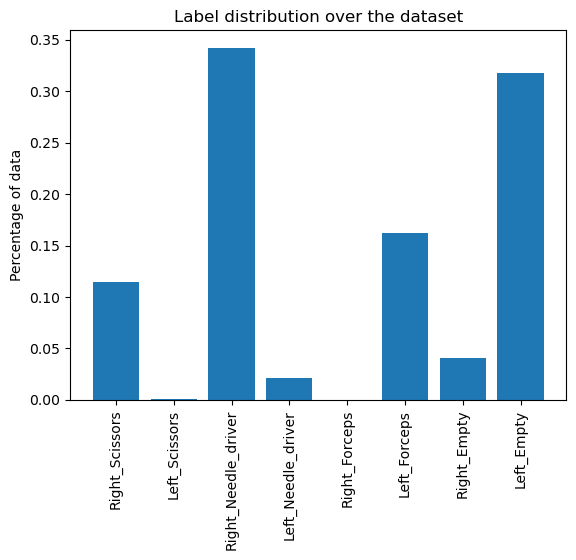

{0: 257, 1: 3, 2: 765, 3: 48, 4: 0, 5: 362, 6: 92, 7: 710}


In [7]:
def count_labels(dataset, classes):
    counter = {c: 0 for c in classes}
    for _, labels in dataset:
        for label in labels:
            counter[label[0]] += 1
    return counter

counts = count_labels(ds, classes_encoding.values())
total = sum(counts.values())
plt.bar(range(len(counts)), [v / total for v in counts.values()], align='center')
plt.title("Label distribution over the dataset")
plt.xticks(range(len(counts)), list(classes_encoding.keys()), rotation=90)
plt.ylabel("Percentage of data")
plt.show()
print(counts)

We observe that the dataset is imbalanced, in particular, the "Right Needle Driver" and "Left Empty" classes dominate the rest of the classes.
The "Left Scissors", "Left Needle Driver" and "Right Empty" are in the extreme minority, accounting for less than 10% of the labels combined, particularly, the "Left Scissors" class has only 3 examples out of 1122.

We theorize that the main factor driving this imbalance is the handedness of the participating surgeons, meaning that the vast majority (if not all) of the participating surgeons were right-handed, which caused the "right" labels and the "left empty" labels to dominate as they were using their preferred hand.

The "Left Forceps" dominates however, due to it being a secondary tool in this procedure and being used in tandem with another tool, therefore it is only used in the left hand since the dominant hand is occupied.

In [8]:
number_class = {v: k for k, v in classes_encoding.items()}
class_color = {0: (255, 0, 0), 1: (0, 255, 0), 2: (0, 0, 255), 3: (255, 255, 0), 4: (0, 255, 255), 5: (255, 0, 255), 6: (128, 128, 128), 7: (128, 0, 128)}
frame, full_label = ds[0]

def draw_bboxes_and_classes(frame_img, label):
    bboxes = [[round(coord) for coord in box[1:]] for box in label]
    classes = [number_class[lbl[0]] for lbl in label]

    for box, cls in zip(bboxes, classes):
        color = class_color[classes_encoding[cls]]
        frame_img = bbv.draw_multiple_rectangles(frame_img, [box], bbox_color=color)
        frame_img = bbv.add_multiple_labels(frame_img, [cls], [box], text_bg_color=color)

    cv.imshow('Frame', frame_img)
    cv.waitKey(0)
    cv.destroyAllWindows()
    cv.waitKey(1)

In [9]:
with open(os.path.join(DATA_ROOT, "train.txt")) as f:
    train_files = [x.split(".")[0] for x in f.readlines()]

with open(os.path.join(DATA_ROOT, "valid.txt")) as f:
    valid_files = [x.split(".")[0] for x in f.readlines()]

with open(os.path.join(DATA_ROOT, "test.txt")) as f:
    test_files = [x.split(".")[0] for x in f.readlines()]

def create_train_test_val_dirs():
    paths_to_create = ["data/raw", "data/raw/images", "data/raw/labels", "data/raw/images/training", "data/raw/images/validation", "data/raw/images/test",
                       "data/raw/labels/training", "data/raw/labels/validation", "data/raw/labels/test",  "data/processed", "data/processed/images",
                       "data/processed/labels", "data/processed/images/training", "data/processed/images/validation", "data/processed/images/test",
                       "data/processed/labels/training", "data/processed/labels/validation", "data/processed/labels/test"]
    for path in paths_to_create:
        if not os.path.exists(path):
            os.mkdir(path)

def split_dataset(ds, train_files, valid_files, test_files, classes):
    counter_train = {c: 0 for c in classes}
    counter_val = {c: 0 for c in classes}
    counter_test = {c: 0 for c in classes}
    create_train_test_val_dirs()
    for i in range(len(ds)):
        img_path, label_path = ds.get_paths(i)
        _, lbl = ds[i]
        img_name = img_path.split("/")[-1].split("\\")[-1].split(".")[0]
        if img_name in train_files:
            for cls in lbl:
                counter_train[cls[0]] += 1
            dest_img = "data/raw/images/training"
            dest_label = "data/raw/labels/training"
        elif img_name in valid_files:
            for cls in lbl:
                counter_val[cls[0]] += 1
            dest_img = "data/raw/images/validation"
            dest_label = "data/raw/labels/validation"
        else:
            for cls in lbl:
                counter_test[cls[0]] += 1
            dest_img = "data/raw/images/test"
            dest_label = "data/raw/labels/test"
        shutil.copy2(img_path, dest_img)
        shutil.copy2(label_path, dest_label)
    return counter_train, counter_val, counter_test

train_counter, val_counter, test_counter = split_dataset(ds, train_files, valid_files, test_files, classes_encoding.values())

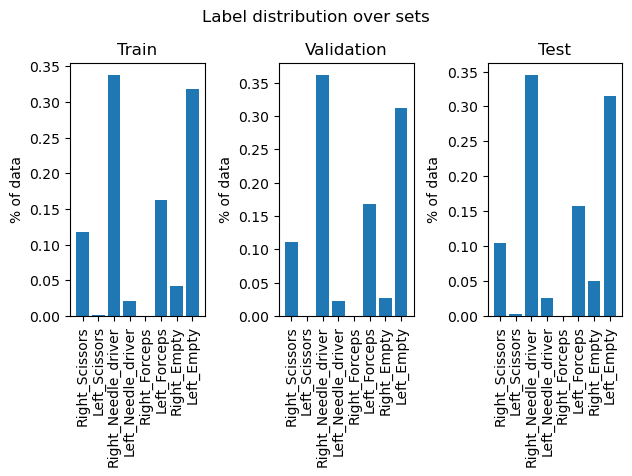

In [10]:
total_train, total_val, total_test = sum(train_counter.values()), sum(val_counter.values()), sum(test_counter.values())

fig, ax = plt.subplots(1, 3)
ax[0].bar(range(len(train_counter)), [v / total_train for v in train_counter.values()], align='center')
ax[0].set_title("Train", fontsize=12)
ax[0].set_xticks(range(len(train_counter)), list(classes_encoding.keys()), rotation=90)
ax[0].set_ylabel("% of data")

ax[1].bar(range(len(val_counter)), [v / total_val for v in val_counter.values()], align='center')
ax[1].set_title("Validation", fontsize=12)
ax[1].set_xticks(range(len(val_counter)), list(classes_encoding.keys()), rotation=90)
ax[1].set_ylabel("% of data")

ax[2].bar(range(len(test_counter)), [v / total_test for v in test_counter.values()], align='center')
ax[2].set_title("Test", fontsize=12)
ax[2].set_xticks(range(len(test_counter)), list(classes_encoding.keys()), rotation=90)
ax[2].set_ylabel("% of data")

fig.suptitle("Label distribution over sets")
fig.tight_layout(pad=1.0)

plt.show()

We can see that the label distribution remains the same after splitting the data according to the train, test and validation files. However, the data is still unbalanced. First, we will use augmentation to increase the size of the minority classes, then we will use oversampling and undersampling to balance the dataset.

In [31]:
from imblearn.over_sampling import RandomOverSampler
import random

def create_labels_df_out_of_subset(images_path, labels_path):
    paths_labels_df = []
    for img_filename, label_filename in zip(os.listdir(images_path), os.listdir(labels_path)):
        with open(os.path.join(labels_path, label_filename)) as f:
            labels = f.readlines()
            for label in labels:
                paths_labels_df.append([img_filename, label_filename, label[0]])
    df = pd.DataFrame(paths_labels_df)
    df.columns = ["img_name", "label_name", "class"]
    return df

def get_balanced_df(org_df):
    oversample = RandomOverSampler(sampling_strategy='auto')
    new_x, new_y = oversample.fit_resample(org_df[['img_name', "label_name"]], org_df['class'])
    new_df = pd.DataFrame()
    new_df["img_name"] = new_x["img_name"]
    new_df["label_name"] = new_x["label_name"]
    new_df["class"] = new_y
    return new_df

def write_balanced_df_to_folder(bdf, images_src, labels_src, images_dest, labels_dest):
    majority = {2, 7}
    counts = bdf.groupby(["img_name", "label_name"]).size().reset_index(name="count")
    for im_name, lbl_name, count in zip(counts["img_name"], counts["label_name"], counts["count"]):
        img_src, lbl_src = os.path.join(images_src, im_name), os.path.join(labels_src, lbl_name)
        for i in range(int(count)):
            if count < 3:
                if random.randint(0, 1):
                    continue
            img_name_dest = im_name.split(".")[0] + f"_{i}" + ".jpg"
            lbl_name_dest = lbl_name.split(".")[0] + f"_{i}" + ".txt"
            img_dest, lbl_dest = os.path.join(images_dest, img_name_dest), os.path.join(labels_dest, lbl_name_dest)
            shutil.copy2(img_src, img_dest)
            shutil.copy2(lbl_src, lbl_dest)
            if i > 2:
                with open(lbl_dest, "r") as f:
                    lines = [x for x in f.readlines() if int(x[0]) not in majority]
                with open(lbl_dest, "w") as f:
                    for line in lines:
                        f.write(line)

def balance_subset(images_src, labels_src, images_dest, labels_dest):
    balance_df = get_balanced_df(create_labels_df_out_of_subset(images_src, labels_src))
    write_balanced_df_to_folder(balance_df, images_src, labels_src, images_dest, labels_dest)
    print(len(balance_df) / len(create_labels_df_out_of_subset(images_src, labels_src)))
    return balance_df

2.365946632782719


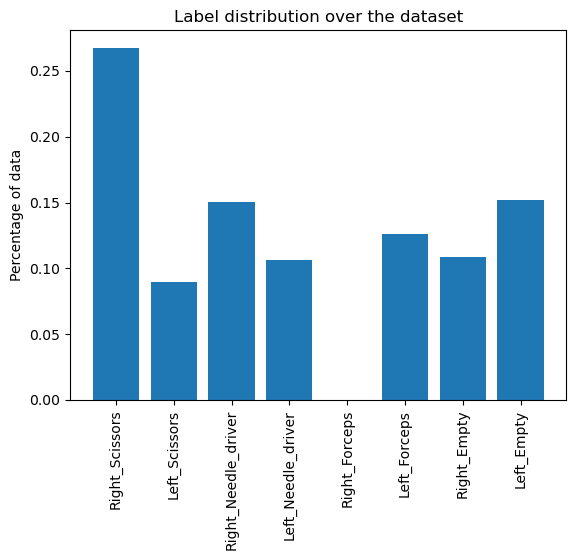

{0: 1609, 1: 541, 2: 905, 3: 639, 4: 0, 5: 757, 6: 652, 7: 912}


In [32]:
counts = {c: 0 for c in range(8)}
for filename in os.listdir("data/processed/labels/training"):
    with open(os.path.join("data/processed/labels/training", filename), "r") as f:
        for line in f.readlines():
            try:
                counts[int(line[0])] += 1
            except ValueError as e:
                print(filename)

total = sum(counts.values())
plt.bar(range(len(counts)), [v / total for v in counts.values()], align='center')
plt.title("Label distribution over the dataset")
plt.xticks(range(len(counts)), list(classes_encoding.keys()), rotation=90)
plt.ylabel("Percentage of data")
plt.show()
print(counts)

We can see that the data is balanced now and nearly double in size

Now, we will train models on the original and balanced train sets

In [ ]:
! jupyter notebook --NotebookApp.iopub_data_rate_limit=1e12

In [12]:
!python yolov5_ws/yolov5/train.py --img 640 --batch 20 --epochs 1000 --device "cuda:0" --data yolov5_ws/yolov5/dataset.yaml --weights yolov5_ws/yolov5/yolov5s.pt

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [1]:
!python yolov5_ws/yolov5/train.py --img 640 --batch 20 --epochs 1000 --device "cuda:0" --data yolov5_ws/yolov5/dataset-balanced.yaml --weights yolov5_ws/yolov5/yolov5s.pt

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5

train: weights=yolov5_ws/yolov5/yolov5s.pt, cfg=, data=yolov5_ws/yolov5/dataset-balanced.yaml, hyp=yolov5_ws\yolov5\data\hyps\hyp.scratch-low.yaml, epochs=1000, batch_size=20, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=cuda:0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5_ws\yolov5\runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5  2022-12-5 Python-3.9.15 torch-1.13.0 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, 


    163/999      4.31G    0.01002   0.008689    0.00364         87        640:  33%|###3      | 56/168 [00:10<00:20,  5.38it/s]
    163/999      4.31G    0.01002   0.008689    0.00364         87        640:  34%|###3      | 57/168 [00:10<00:20,  5.43it/s]
    163/999      4.31G    0.01003   0.008711    0.00361         75        640:  34%|###3      | 57/168 [00:10<00:20,  5.43it/s]
    163/999      4.31G    0.01003   0.008711    0.00361         75        640:  35%|###4      | 58/168 [00:10<00:20,  5.28it/s]
    163/999      4.31G    0.01005    0.00874   0.003632         76        640:  35%|###4      | 58/168 [00:11<00:20,  5.28it/s]
    163/999      4.31G    0.01005    0.00874   0.003632         76        640:  35%|###5      | 59/168 [00:11<00:20,  5.36it/s]
    163/999      4.31G    0.01006   0.008723   0.003692         66        640:  35%|###5      | 59/168 [00:11<00:20,  5.36it/s]
    163/999      4.31G    0.01006   0.008723   0.003692         66        640:  36%|###5      | 60/168 